In [1]:

%matplotlib notebook
from importlib import reload
import numpy as np
from tqdm import tnrange
from scipy.stats import multivariate_normal as mvn
import copy
import matplotlib.pyplot as plt
from math import atan2, log, ceil
import os

In [2]:

import roadmap
reload(roadmap)
from roadmap import Roadmap
import pf
reload(pf)
from pf import PFJupyter as PF
import particle
reload(particle)
from particle import Particle
import mode_splitting
reload(mode_splitting)
from mode_splitting import getModeProbabilities, getAvgModeDataOverTime, plotModeData

def fill_prediction(ent):
    for idx in range(1,len(ent)):
        if np.isnan(ent[idx]):
            for jdx in range(idx,len(ent)):
                if not np.isnan(ent[jdx]):
                    slope = (ent[jdx]- ent[idx-1])/(jdx-(idx-1))
                    for kdx in range(idx, jdx):
                        ent[kdx] = ent[idx-1] + slope*(kdx-(idx-1))
                    break

    return ent
def getEntropyLowerBoundFromFormula(dists, num_edges, probability_array, dt, sigma):
    lower_bounds = []
    for idx in range(len(dists)):
        entropy_data = np.load("data/data_2x3-{}-1_h_0.npy".format(dists[idx]))
        variance_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dists[idx]))
        avg_min_variance, variance_mins = get_avg_min_variance(variance_data, entropy_data)
        print(avg_min_variance)
        map_size = num_edges*dists[idx]
        predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt, sigma,
                                                                         len(probability_array[idx]),
                                                                         probability_array[idx], 1)
        fill_prediction(np.copy(predicted_ent))
        lower_bounds.append(np.nanmean(predicted_ent))
    return lower_bounds
def probabilityMode2Time(probabilities):
    probabilites_by_time = []
    for jdx in range(len(probabilities[1])):
        probabilites_by_time.append({})
        for key in probabilities.keys():
            probabilites_by_time[-1][key] = probabilities[key][jdx]
    return probabilites_by_time

def getInitialVariance(x,y,dist, Va, dt, sigma, R):
    dur = getDuration(x,y,dist, Va)
    return (-(dur*dt*sigma**2)+np.sqrt((dur*dt*sigma**2)**2 + 4*R*dur*dt*sigma**2))/2

def getLowerBoundsForMap(dist, num_edges, dt, sigma, Va, R, probability_by_time):
    data = np.load("data/data_2x3-{}-1_h_0.npy".format(dist))
    v_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dist))
    plot_data = np.mean(data, axis=0)
    t = np.array([idx*dt for idx in range(plot_data.shape[0])])

    avg_min_variance, variance_mins = get_avg_min_variance(v_data, data)

    dur = len(probability_by_time)*dt

    avg_min_variance = getInitialVariance(2,3,dist,Va,dt,sigma,R)

    map_size = num_edges*dist
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt,
                                                                     sigma, len(probability_by_time),
                                                                     probability_by_time, 1)
    fill_prediction(np.copy(predicted_ent))

    lower_bound = np.mean(plot_data[750:])
    predicted_lower_bound = np.nanmean(predicted_ent)
    return t, lower_bound, predicted_lower_bound, avg_min_variance

def getLowerBounds(dists, num_edges, dt, sigma, Va, R, probability_array):
    lower_bounds = []
    predicted_lower_bounds = []
    avg_min_variances = []
    for idx in range(len(dists)):
        
        t, lower_bound, predicted_lower_bound, avg_min_variance = getLowerBoundsForMap(dists[idx], num_edges,
                                                                                       dt, sigma, Va, R,
                                                                                       probability_array[idx])
        lower_bounds.append(lower_bound)
        predicted_lower_bounds.append(predicted_lower_bound)
        avg_min_variances.append(avg_min_variance)
    return lower_bounds, predicted_lower_bounds, avg_min_variances

def getMapDict2x3(dist, v0):
    edge_dur = dist/v0
    return {
        'base': {
            'offsets': [0,0],
            'options': [0,1],
            'range': [3*edge_dur, edge_dur],
            'prob': [6./7, 1./7]
        },
        0: {'offsets': [3*edge_dur,edge_dur],
           'options': [0,1],
           'range': 3*edge_dur,
           'prob':6./7},#4/6
        1: {'offsets': [3*edge_dur,3*edge_dur],
           'options': [0,0],
           'range': edge_dur,
           'prob': 1./7}
    }

def getMapDict3x3(dist, v0):
    edge_dur = dist/v0
    return {
        'base': {
            'offsets': [0,0,0],
            'options': [0,1,2],
            'range': [2*edge_dur, edge_dur, edge_dur],
            'prob': [4./6, 1./6, 1./6]
        },
        0: {'offsets': [2*edge_dur,edge_dur],
           'options': [0,1],
           'range': 2*edge_dur,
           'prob':4./6},#4/6
        1: {'offsets': [edge_dur, edge_dur, edge_dur],
           'options': [2,2,2],
           'range': edge_dur,
           'prob': 1./6},#1/6
        2: {'offsets': [2*edge_dur,2*edge_dur],
           'options': [0,0],
           'range': edge_dur,
           'prob': 1./6}#1/6
    }

def getDuration(x,y, dist, Va):
    nodes, edges = createGridLayout(x,y,dist, dist)
    r = Roadmap(nodes, edges, rotate=False)
    avg_dist = getAvgDistance(r)
    dur = 2*avg_dist/Va
    return dur;

def getProbabilityByDistsByTime(dists, dt, Va, v0, dur=None):
    probability_array = [[],[]]
    for idx in range(len(dists)):
        if dur is None:
            dur = getDuration(2,3,dists[idx], Va)
        map_dict2x3 = getMapDict2x3(dists[idx], v0)
        t, test_data, prob_data = getModeProbabilities(map_dict2x3, dt, dur)
        probability_array[0].append(probabilityMode2Time(prob_data))
        
        if dur is None:
            dur = getDuration(3,3, dists[idx], Va)
        map_dict3x3 = getMapDict3x3(dists[idx], v0)
        t, test_data, prob_data = getModeProbabilities(map_dict3x3, dt, dur)
        probability_array[1].append(probabilityMode2Time(prob_data))
    return probability_array

def getSuperComputerData(dists):
    for idx in range(len(dists)):
        try:
            try:
                ent = np.load("data/entropy_growth_2x3-{}-1_h_0.npy".format(dists[idx]))
                ent = np.concatenate((ent, np.load("data/entropy_growth_2x3-{}-1_h.npy".format(dists[idx]))), axis=0)
            except:
                ent = np.load("data/entropy_growth_2x3-{}-1_h.npy".format(dists[idx]))
            np.save("data/entropy_growth_2x3-{}-1_h_0.npy".format(dists[idx]), ent)
            os.remove("data/entropy_growth_2x3-{}-1_h.npy".format(dists[idx]))
        except:
            pass
        try:
            try:
                ent = np.load("data/entropy_growth_3x3-{}-1_h_0.npy".format(dists[idx]))
                ent = np.concatenate((ent, np.load("data/entropy_growth_3x3-{}-1_h.npy".format(dists[idx]))), axis=0)
            except:
                ent = np.load("data/entropy_growth_3x3-{}-1_h.npy".format(dists[idx]))
            np.save("data/entropy_growth_3x3-{}-1_h_0.npy".format(dists[idx]), ent)
            os.remove("data/entropy_growth_3x3-{}-1_h.npy".format(dists[idx]))
        except: pass
    dt = .1
    plt.figure()
    for idx in range(len(dists)):
        try:
            try:
                data = np.load("data/data_2x3-{}-1_h_0.npy".format(dists[idx]))
                v_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dists[idx]))
        #         print(data.shape)
        #         print(v_data.shape)
                data = np.concatenate((data, np.load("data/data_2x3-{}-1_h.npy".format(dists[idx]))), axis=0)
                v_data = np.concatenate((v_data, np.load("data/data_2x3-{}-1_v.npy".format(dists[idx]))),axis=0)
            except:
                pass
                data = np.load("data/data_2x3-{}-1_h.npy".format(dists[idx]))
                v_data = np.load("data/data_2x3-{}-1_v.npy".format(dists[idx]))
            print(data.shape)
            print(v_data.shape)
            np.save('data/data_2x3-{}-1_h_0'.format(dists[idx]), data)
            np.save('data/data_2x3-{}-1_v_0'.format(dists[idx]), v_data)
            os.remove("data/data_2x3-{}-1_h.npy".format(dists[idx]))
            os.remove("data/data_2x3-{}-1_v.npy".format(dists[idx]))
            plot_data = np.mean(data, axis=0)
            plot_data = np.mean(plot_data, axis=1)
            t = [idx*dt for idx in range(plot_data.shape[0])]
            plt.plot(t, plot_data, label=dists[idx])
        except:
            pass
    plt.legend()

    dists = [50, 100, 150, 200, 250, 300]
    plt.figure()
    for idx in range(len(dists)):
        try:
            try:
                data = np.load("data/data_3x3-{}-1_h_0.npy".format(dists[idx]))
                v_data = np.load("data/data_3x3-{}-1_v_0.npy".format(dists[idx]))
        #         print(data.shape)
        #         print(v_data.shape)
                data = np.concatenate((data, np.load("data/data_3x3-{}-1_h.npy".format(dists[idx]))),axis=0)
                v_data = np.concatenate((v_data, np.load("data/data_3x3-{}-1_v.npy".format(dists[idx]))),axis=0)
            except:
                data = np.load("data/data_3x3-{}-1_h.npy".format(dists[idx]))
                v_data = np.load("data/data_3x3-{}-1_v.npy".format(dists[idx]))

            print(data.shape)
            print(v_data.shape)
            np.save('data/data_3x3-{}-1_h_0'.format(dists[idx]), data)
            np.save('data/data_3x3-{}-1_v_0'.format(dists[idx]), v_data)
            os.remove("data/data_3x3-{}-1_h.npy".format(dists[idx]))
            os.remove("data/data_3x3-{}-1_v.npy".format(dists[idx]))
            plot_data = np.mean(data, axis=0)
            plot_data = np.mean(plot_data, axis=1)
            t = [idx*dt for idx in range(plot_data.shape[0])]
            plt.plot(t, plot_data, label=dists[idx])
        except:
            pass
    plt.legend()

def get_avg_min_variance(v, h):
    v = np.array(v)
    mins = []
    for jdx in range(h.shape[0]):
        test = h[jdx,:,0]
        for idx in range(test.shape[0]-1):
            if test[idx] > test[idx+1]+1:
                mins.append(v[jdx,idx+1,0])
    return np.mean(mins), mins

def plotSimEntropy(dists, colors):
    fig, ax = plt.subplots(1,2, sharey=True)
    max_x = [0, 0]
    ax[0].set_title("2x3 Map")
    for idx in range(len(dists)):
        data = np.mean(np.mean(np.load("data/data_2x3-{}-1_h_0.npy".format(dists[idx])),axis=0),axis=1)
        v_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dists[idx]))
        t = [idx*dt for idx in range(data.shape[0])]
        max_x[0] = max(max_x[0], data.shape[0])
        ax[0].plot(t, data, color=colors[idx], label=dists[idx])
    ax[0].legend()

    ax[1].set_title("3x3 Map")
    for idx in range(len(dists)):
        data = np.mean(np.mean(np.load("data/data_3x3-{}-1_h_0.npy".format(dists[idx])),axis=0),axis=1)
        v_data = np.load("data/data_3x3-{}-1_v_0.npy".format(dists[idx]))
        t = [idx*dt for idx in range(data.shape[0])]
        ax[1].plot(t, data, color=colors[idx], label=dists[idx])
        max_x[1] = max(max_x[1], data.shape[0])
    ax[1].legend()
    return ax, max_x

def getProbabilityArrayByTimeByMap(dists, v0, duration):
    probability_array_2x3 = []
    probability_array_3x3 = []
    for dist_e in dists:
        edge_dur = dist_e/v0
        duration = 50
        v0 = 10
        map_dict2x3 = {
            'base': {
                'offsets': [0,0],
                'options': [0,1],
                'range': [3*edge_dur, edge_dur],
                'prob': [6./7, 1./7]
            },
            0: {'offsets': [3*edge_dur,edge_dur],
               'options': [0,1],
               'range': 3*edge_dur,
               'prob':4./6},#4/6
            1: {'offsets': [3*edge_dur,3*edge_dur],
               'options': [0,0],
               'range': edge_dur,
               'prob': 1./7}
        }
        t, test_data, probabilities = getModeProbabilities(map_dict2x3, dt, duration)
        probabilites_by_time = []
        for jdx in range(len(probabilities[1])):
            probabilites_by_time.append({})
            for key in probabilities.keys():
                probabilites_by_time[-1][key] = probabilities[key][jdx]
        probability_array_2x3.append(probabilites_by_time)
        map_dict3x3 = {
            'base': {
                'offsets': [0,0,0],
                'options': [0,1,2],
                'range': [2*edge_dur, edge_dur, edge_dur],
                'prob': [4./6, 1./6, 1./6]
            },
            0: {'offsets': [2*edge_dur,edge_dur],
               'options': [0,1],
               'range': 2*edge_dur,
               'prob':4./6},#4/6
            1: {'offsets': [edge_dur, edge_dur, edge_dur],
               'options': [2,2,2],
               'range': edge_dur,
               'prob': 1./6},#1/6
            2: {'offsets': [2*edge_dur,2*edge_dur],
               'options': [0,0],
               'range': edge_dur,
               'prob': 1./6}#1/6
        }
        t, test_data, probabilities = getModeProbabilities(map_dict3x3, dt, duration)
        probabilites_by_time = []
        for jdx in range(len(probabilities[1])):
            probabilites_by_time.append({})
            for key in probabilities.keys():
                probabilites_by_time[-1][key] = probabilities[key][jdx]
        probability_array_3x3.append(probabilites_by_time)
    return probability_array_2x3, probability_array_3x3

def get_avg_min_variance(v, h):
    v = np.array(v)
    mins = []
    for jdx in range(h.shape[0]):
        test = h[jdx,:,0]
#         print(test.shape)
#         print(h[jdx].shape, v[jdx].shape)
        for idx in range(test.shape[0]-1):
            
            if test[idx] > test[idx+1]+1:
#                 print(v[jdx].shape)
                mins.append(v[jdx,idx+1,0])
    return np.mean(mins), mins

def DjikstraGraph(graph, initial_node):
    nodes = sorted(graph.keys())
    unvisited = sorted(graph.keys())
    visited = []
    dists = []
    paths = []
    for node in nodes:
        dists.append(np.inf)
        paths.append([])
        if node == initial_node:
            dists[-1] = 0
    while len(visited) < len(nodes):
        best_node = None
        best_node_val = -1
        for node in unvisited:
            if dists[nodes.index(node)] < best_node_val or best_node is None:
                best_node_val = dists[nodes.index(node)]
                best_node = node
        start_node = best_node
        visited.append(start_node)
        unvisited.remove(start_node)
        index_start = nodes.index(start_node)
        for node in graph[start_node].keys():
            index = nodes.index(node)
            new_dist = dists[index_start] + graph[start_node][node]
            if new_dist < dists[index]:
                dists[index] = new_dist
                paths[index] = paths[index_start]
                paths[index].append(node)
    return dists

def getAvgDistance(r):
    vals = []
    for node in sorted(r.graph.keys()):
        avg_dist = np.mean(DjikstraGraph(r.graph, node))
        vals.append(avg_dist)
    return np.mean(vals)

def createGridLayout(x,y,min_edge_length, max_edge_length):
    nodes = []
    edges = []
    for i in range(y):
        for j in range(x):
            x_val = 0
            y_val = 0
            if i > 0:
                y_val = nodes[(i-1)*x + j][1]+ np.random.uniform(low=min_edge_length, high=max_edge_length)
            if j > 0:
                x_val = nodes[i*x+j-1][0]+ np.random.uniform(low=min_edge_length, high=max_edge_length)
            nodes.append((
                x_val,
                y_val ))

    for i in range(y):
        for j in range(x-1):
            edges.append((j+x*i,j+1+x*i))
    
    for i in range(y-1):
        for j in range(x):
            edges.append((j+x*i,j+x*(i+1)))
    return [nodes, edges]

def getEntropy(probability, mode_probability):
    entropy = 0
    for num_modes in mode_probability.keys():
        for idx in range(len(probability)):
            if np.isfinite(np.log((1/num_modes)*probability[idx])) and probability[idx] > 0:
                entropy += mode_probability[num_modes]*(-probability[idx]*np.log((1/num_modes)*probability[idx]))
    return entropy

def getProbAndEntropy(variance, x, mu, mode_probability,step_size, zero_out):
    probability = 1./np.sqrt(2*np.pi*variance)*np.exp(-(x-mu)**2/(2*variance))
    cdf = []
    for idx in range(0,len(probability),step_size):
        cdf.append(sum(probability[:idx]))
    probability = cdf - np.concatenate(([0], cdf[0:-1]))
    if zero_out:
        probability[probability<(1/1000)] = 0
    entropy = getEntropy(probability, mode_probability)
    return probability, entropy

def getProbAndEntropyOverTime(var_0, map_size, dt, sigma, num_steps, mode_probability, step_size=1, zero_out=False):
    mu = map_size/2.
    distance = np.array([idx for idx in range(0,int(map_size), 1)])
    prob_over_time = []
    entropy_over_time = []
    for idx in range(num_steps):
        var = var_0 + idx*(dt*sigma)**2
#         print(mode_probability[idx])
#         print(mode_probability)
        prob, entropy = getProbAndEntropy(var, distance, mu, mode_probability[idx], step_size, zero_out)
        prob_over_time.append(prob)
        entropy_over_time.append(entropy)
    return prob_over_time, entropy_over_time

def calc_entropy(r, X, res=1):
    """Returns the entropy of the estimate in nats
        
        r -- roadmap graph on which the particles exist
        X -- state of each particle, shape=(M, N, 12),
             M = number of targets
             N = number of particles
        """
    
    ## x, y, speed, start_x, start_y, end_x, end_y, direction_x, direction_y, distance, sigma, w
    M = X.shape[0]
    N = X.shape[1]
    # calculate the distance of each particle from the beginning of its road segment
    dists = np.linalg.norm(X[:, :, :2] - X[:, :, 3:5], axis=-1)
    dists_reverse = np.linalg.norm(X[:, :, :2] - X[:, :, 5:6], axis=-1)
    
    h = 0.0
    hist = []
    nodes_visited = []
    counts = []
    probs = []
    for start in r.keys():
#         if start not in nodes_visited:
#             nodes_visited.append(start)
            for end in r[start].keys():
#                 if end not in nodes_visited:
#                     nodes_visited.append(end)
                length = r[start][end]
                bin_start = 0.0
#                 bin_start_reverse = 1.0
                # find the particles on this road segment
                on_edge = np.all(X[:, :, 3:7] == start + end, axis=-1)
#                 on_edge_reverse = np.all(np.flip(X[:, :, 3:7], axis=2) == end + start, axis=-1)
                while bin_start < length:
                    in_bin = np.all([dists >= bin_start, dists <= bin_start + res], axis=0)
#                     in_bin_reverse = np.all([dists_reverse >= bin_start, dists_reverse <= bin_start + res], axis=0)

                    count = np.sum(np.all([on_edge, in_bin], axis=0))# + np.sum(np.all([on_edge, in_bin_reverse], axis=0))
                    counts.append(count)
                    p = count / (N*M)
                    probs.append(p)
                    hist.append(p)
                    if p > 0:
                        h -= p*np.log(p)
                    bin_start += res
    return h, get_pos_var(X, hist), counts, probs

def get_pos_var(X, bins):
    return max(np.var(X[:,:,0:1]), np.var(X[:,:,1:2]))

class RB_PF(object):
    def __init__(self, roadmap, num_particles, max_vehicles, pf_args):
        self._roadmap = roadmap
        self._N = num_particles
        self._max_vehicles = max_vehicles
        self.X = [[PF(**pf_args) for j in range(self._max_vehicles)] for i in range(self._N)]
        self.best = self.X[0]
        self.no_measurements = True
        
    def lowVarSample(self, w):
        Xbar = []
        M = self._N
        r = np.random.uniform(0, 1/M)
        c = w[0]
        i = 0
        last_i = i
        unique = 1
        for m in range(M):
            u = r + m/M
            while u > c:
                i += 1
                c = c + w[i]
            new_x = copy.deepcopy(self.X[i])
            Xbar.append(new_x)
            if i == self.best_idx:
                self.best = new_x
            if last_i != i:
                unique += 1
            last_i = i
        self.X = Xbar
        return unique

    def predict(self):
        # propagate each bank of particle filters
        [[xi.predict() for xi in x] for x in self.X]
    
    def update(self, z, R, lone_target, radius=None, p_fa=None):
        w = np.zeros(self._N)

        for i, x in enumerate(self.X):
            if self.no_measurements:
                t = 0
            else:
                # get the likelihood that the measurement came from each target
                l = np.array([xi.get_measurement_likelihood(z, R) for xi in x])

                # normalize the likelihoods so we can randomly choose a corresponding target
                # with some smart probabilites
                if np.sum(l) < 10*np.finfo(float).eps:
                    continue
                l = l/np.sum(l)
                t = np.where(np.random.multinomial(1, l) == 1)[0][0]
                
            w[i] = x[t].get_measurement_likelihood(z, R)
            x[t].update(z, R)
            if lone_target:
                for j, xi in enumerate(x):
                    if t != j:
                        xi.neg_update(z, radius)
        self.no_measurements = False
            
            
        # logsumexp
        max_w = np.max(w)
        w = np.exp(w-max_w)
        # for code simplicity, normalize the weights here
        w = w/np.sum(w)
#         print("best: {}={}".format(np.argmax(w), np.max(w)))
        
        self.best_idx = np.argmax(w)        
        self.best = self.X[self.best_idx]
        unique = self.lowVarSample(w)
#         print(unique)

    
    def neg_update(self, z, radius):
        [[xi.neg_update(z, radius) for xi in x] for x in self.X]

def sim(rbpf, r, targets, R, dt, T_end, plot=True, agent=None):
    if plot:
        fig, ax = plt.subplots()
        r.visualize(ax)

        x0 = rbpf.best[0].X[:,0]
        y0 = rbpf.best[0].X[:,1]
        sc1 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='green', label='particles')
        loc = r.get_loc(targets[0].state)
        sc_target1 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='green', label='target')

    #     x0 = rbpf.best[1].X[:,0]
    #     y0 = rbpf.best[1].X[:,1]
    #     sc2 = ax.scatter(x0, y0, s=10, linewidth=0, facecolor='blue', label='particles')
    #     loc = r.get_loc(target2.state)
    #     sc_target2 = ax.scatter([loc[0]], [loc[1]], s=100, marker='*', facecolor='blue', label='target')
        if agent is not None:
            agent.init_plot(ax)
        ax.legend()
        #ax.plot([50, 60], [50, 50], marker='o', ls='None')

        ax.set_xlim(-20, 450)
        ax.set_ylim(-20, 320)
        ax.set_aspect('equal')
        # plt.plot([0,1,1,2])
        # plt.show()
        fig.canvas.draw()
        start = time.time()
        tic = start
    H = []
    Ts = dt
    avg_distance = [[] for pf in rbpf.best]
    num_in_threshold = [[] for pf in rbpf.best]
    variances = []
    counts = []
    probs = []
    particles = []
    for i in range(15):
        targets[0].predict()
        rbpf.predict()
        rbpf.update(mvn.rvs(targets[0].loc, R), R, lone_target=True, radius=1)
    
    # update the scenario
    for i in range(int(T_end/Ts)):
#     for i in tqdm(range(int(T_end/Ts))):
        rbpf.predict()
        dists = []
        for target in targets:
            target.predict()
            if agent is not None:
                dists.append(np.linalg.norm(target.loc - agent.pos))
        if agent is not None:
            if agent is not None:
                if i % int(1/Ts) == 0 and i != 0:
        #             if (dist1 < agent.fov) != (dist2 < agent.fov):
                    if dists[0] < agent.fov:
                        z = mvn.rvs(targets[0].loc, R)
                        rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
        #                 if dist2 < agent.fov:
        #                     z = mvn.rvs(target2.loc, R)
        #                     rbpf.update(z, R, lone_target=True, radius=agent.fov*0.75)
        #             elif (dist1 < agent.fov) and (dist2 < agent.fov):
        #                     z = mvn.rvs(target1.loc, R)
        #                     rbpf.update(z, R, lone_target=False)
        #                     z = mvn.rvs(target2.loc, R)
        #                     rbpf.update(z, R, lone_target=False)
                    else:
                        rbpf.neg_update(agent.pos, radius=agent.fov*0.75)
        if plot:
            locs1 = rbpf.best[0].X[:,:2]
            sc1.set_offsets(locs1)
    #         locs2 = rbpf.best[1].X[:,:2]
    #         sc2.set_offsets(locs2)
            sc_target1.set_offsets(targets[0].loc)
    #         sc_target2.set_offsets(target2.loc)
            pfs = rbpf.best
        pfs = rbpf.best
        if agent is not None:
            agent.update(None)
        if plot:
            fig.canvas.draw()
            toc = time.time()
            dur = toc - tic
            tic = toc
        X = np.array([rbpf.best[i].X for i in range(len(rbpf.best))])
        H_current, var_pos, part_dist, p = calc_entropy(r.graph, X)
        H += [H_current]
        variances.append(var_pos)
        counts += [part_dist]
        probs += [p]
        particles += [X]
#         variances[1].append(var_vel)

    return H, variances, counts, probs, particles

def runIterations(nodes, edges, N, dt, T_end, num_runs, P_fa=.02, P_miss=.05, v0=4.5,
                  sigma=4, num_targets=1, e0=None, x0=None, one_edge=False, plot=False, agent_path=None,
                 get_entropy=True, get_variance=False, get_counts=False, get_prob=False, get_particles=False):
    r = Roadmap(nodes, edges, rotate=False)
    pf_args = {'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':v0, 'sigma':sigma,
               'P_fa':P_fa, 'P_miss':P_miss, 'one_edge': one_edge}
    R = 5*np.eye(2)
    H = []
    variances = []
    counts = []
    probs = []
    particles = []
    for idx in tnrange(num_runs):
        rbpf = RB_PF(r, 10, num_targets, pf_args)
        targets = []
        for jdx in range(num_targets):
            if x0 is not None:
                targets.append(Particle(r, v0=v0, dt=dt,e0=e0[jdx], x0=x0[jdx], sigma=sigma))
            else:
                targets.append(Particle(r, v0=v0, dt=dt, sigma=sigma))
        
#         agent = AgentRandom((100, 60), 100, 50, 40, 30, r, dt=dt)
        if agent_path is None:
            agent = None
        else:
            agent = AgentPerfect((100, 60), 100, 50, 40, 30, r, dt=dt, path=agent_path)
        H_tmp, variance, count, prob, part = sim(rbpf, r, targets, R, dt, T_end, plot=plot, agent=agent)
        if get_entropy:
            H += [H_tmp]
        if get_variance:
            variances += [variance]
        if get_counts:
            counts += [count]
        if get_prob:
            probs += [prob]
        if get_particles:
            particles += [part]
    return_data = []
    if get_entropy:
        h = np.nanmean(H, axis=0)
        return_data.append(h)
    if get_variance:
        v = np.nanmean(variances, axis=0)
        return_data.append(v)
    if get_counts:
        c = np.nanmean(counts, axis=0)
        return_data.append(c)
    if get_prob:
        p = np.nanmean(probs, axis=0)
        return_data.append(p)
    if get_particles:
        particles = np.array(particles)
        return_data.append(particles)
    return return_data



# Variance

In [3]:
dt = 0.1
v0 = 4.5
sigma = 4
Va = 40

## Initial Variance

<IPython.core.display.Javascript object>


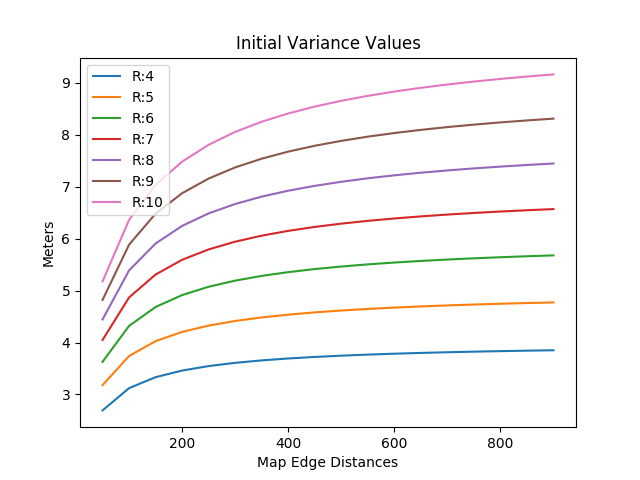

Text(0.5,1,'Initial Variance Values')

In [4]:
dists = [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900]
R_vals = [4,5,6,7,8,9,10]
plt.figure()
for jdx in range(len(R_vals)):
    R = R_vals[jdx]
    durations = []
    for idx in range(len(dists)):
        dur = getInitialVariance(2,3,dists[idx], Va, dt, sigma, R)
        durations.append(dur)
    plt.plot(dists, durations, label="R:{}".format(R))
plt.legend()
plt.xlabel("Map Edge Distances")
plt.ylabel("Meters")
plt.title("Initial Variance Values")


## Linear Growth

In [47]:
dist_e = 300
nodes = [(0.,0.), (dist_e,0.)]

edges = [(0, 1)]

N = 1000
T_end = 55
num_runs = 100
h, v, p = runIterations(nodes, edges, N, dt, T_end, num_runs, v0=v0,
                           sigma=sigma, e0=[(nodes[1], nodes[0])], x0=[.03], one_edge=True,
                           get_entropy=True, get_variance=True, get_prob=True)
np.save("VarianceGrowthData", v)
np.save("ProbabilityGrowthData", p)

In [48]:
v = np.load("VarianceGrowthData.npy")
p = np.load("ProbabilityGrowthData.npy")
predicted_v = [v[0] + idx*(dt*sigma)**2 for idx in range(v.shape[0])]
mu = 300
max_dist = 300
x = np.array([i for i in range(int(mu-max_dist),int(mu+max_dist),1)])

ent = []
predicted_ent = []
p_by_time = []
p_est_by_time = []
predicted_est_by_time = []
bias = 0
map_size = 600
mode_probability = [{1:1} for idx in range(v.shape[0])]
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(v[0], map_size, dt, sigma, v.shape[0],
                                                                 mode_probability)
for idx in range(v.shape[0]):
    #calculate entropy and probability based on variance
    var = v[idx]
    est, entropy = getProbAndEntropy(var, x, mu, mode_probability[idx], 1)
#     print(entropy)
    p_est_by_time.append(est)
    ent.append(entropy)
entropy_from_sim_prob = []
for idx in range(p.shape[0]):
    entropy_from_sim_prob.append(getEntropy(p[idx], {1:1}))
    
p_est_by_time = np.array(p_est_by_time)
#rk4
# 0 order whole

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:404: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


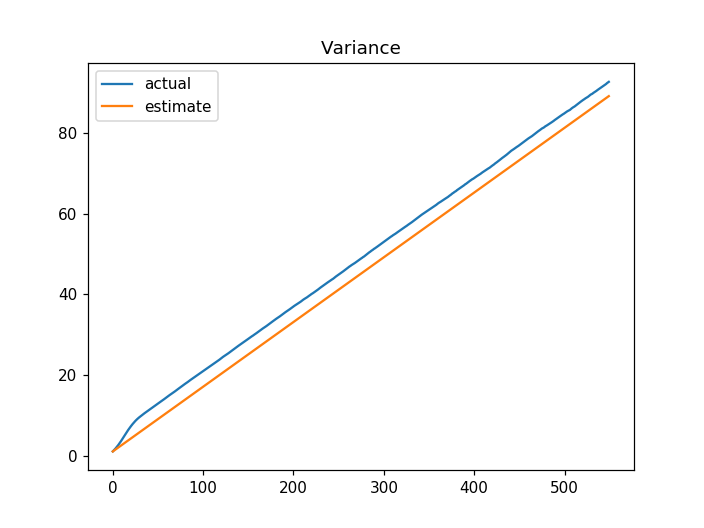

In [49]:
# print(predicted_v)
fig, ax = plt.subplots()
ax.set_title("Variance")
ax.plot(v, label='actual')
ax.plot(predicted_v, label='estimate')
ax.legend()

In [50]:
# Va = 30
# dist_e = 350
# # intersections
# i = [(0.,0.), (dist_e,0.),
#      (0.,100), (dist_e,100)]
# edges = [(0, 1), 
#          (0, 2), 
#          (1, 3),
#          (2, 3)
#         ]

# # initialize the roadmap
# r = Roadmap(i, edges, rotate=False)

# sigma_vel = 10

# N = 1000
# dt = 0.3
# T_end = 200
# num_runs = 200

# P_fa = 0.0
# P_miss = 0.0
# R = 1*np.eye(2)
# H_sets = []
# V_sets =[]
# sigmas = []
# for jdx in tnrange(7, desc='sigmas'):
#     H = []
#     V = []
#     sigma_vel = (jdx+1)*2
#     sigmas.append(sigma_vel)
#     pf_args = {
#         'roadmap':r, 'num_particles':N, 'dt':dt, 'v0':0, 
#         'sigma':sigma_vel, 'P_fa':P_fa, 'P_miss':P_miss}
#     for i in tnrange(num_runs, desc='runs', leave=False):
#         target1 = Particle(r, v0=0, dt=dt, e0=((0,0),(dist_e,0)), x0=.5, sigma=2)
#         target2 = Particle(r, v0=0, dt=dt, sigma=2)
#         targets = [target1]#, target2]
#         rbpf = RB_PF(r, 10, len(targets), pf_args)

#         Va = 30
#         agent = AgentSimple((dist_e/2, 0), 100, 50, Va, 30, r, dt=dt)

#         H_current, variances = sim(r, rbpf, targets, agent, R, dt, T_end, plot=False)
#         H += [H_current]
#         V += [variances]
#     H_sets += [H]
#     V_sets += [V]

In [51]:
# N = 1000
# dt = 0.1
# T_end = 55
# num_runs = 20
# V_sets = []
# sigmas = []
# v0 = 4.5
# dists = [300, 600, 900, 1200, 1500, 2000, 3000]
# for jdx in tnrange(7, desc='sigmas'):
#     sigma = (jdx+1)*2
#     sigmas.append(sigma)
#     dist_e = dists[jdx]#300*(jdx+1)*2
#     nodes = [(0.,0.), (dist_e,0.)]
#     edges = [(0, 1)]
#     h, v, p = runIterations(nodes, edges, N, dt, T_end, num_runs, v0=v0,
#                                sigma=sigma, e0=[(nodes[1], nodes[0])], x0=[.03], one_edge=True,
#                                get_entropy=True, get_variance=True, get_prob=True)
#     V_sets.append(v)
# np.save("InitialVarianceSimulatorData", V_sets)

In [52]:
# fig, ax = plt.subplots()
# # sigmas_vel = [(jdx+1)*2 for jdx in range(3)]
# # print(V_sets[0])
# for i in range(5):#len(V_sets)):
#     v = V_sets[i]#np.mean(V_sets[i], axis=0)
#     t = np.array([x*dt for x in range(int(T_end/dt))])
#     ax.plot(t,v, label='{}'.format(sigmas[i]))
#     ax.plot(t,v[0]+t*dt*(sigmas[i])**2, label='{}-est'.format(sigmas[i]))
# # ax.plot(t,v)
# ax.legend()
# # for i in range(len(V_sets)):
# #     v = np.mean(V_sets[i], axis=0)
# #     print(v.shape)
# #     mean = [1000, 1500, 1750, 1875, 1937,1969]
# #     ranges = 10
# #     print([
# #         '{:.4f} {:.4f}'.format(np.min(v[mean[idx]-ranges:mean[idx]+ranges]), np.max(v[mean[idx]-ranges:mean[idx]+ranges]))
# #         for idx in range(len(mean))])

# Mode Splitting

## 2x3
### Without Merging
#### From Simulator

In [83]:
import mode_splitting
reload(mode_splitting)
from mode_splitting import getModeProbabilities, getAvgModeDataOverTime, plotModeData

dt = .1
duration = 60
num_runs = 10000
dists = [50, 100, 150, 200, 250, 300]
for idx in tnrange(len(dists)):
    dist_e = dists[idx]
    layout = (2,3)
    modes_over_time_2x3_raw = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs)
    np.save("data/ModesFromSimulation2x3-{}".format(dist_e), modes_over_time_2x3_raw)
#     modes_over_time_2x3_raw = np.load('data/ModesFromSimulation2x3-{}.npy'.format(dist_e)).item()
    modes_over_time_2x3 = {}
    for key in modes_over_time_2x3_raw.keys():
        modes_over_time_2x3[key] = key*modes_over_time_2x3_raw[key]
    
    layout = (3,3)
    modes_over_time_3x3_raw = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs)
    np.save("data/ModesFromSimulation3x3-{}".format(dist_e), modes_over_time_3x3_raw)
#     modes_over_time_2x3_raw = np.load('data/ModesFromSimulation3x3-{}.npy'.format(dist_e)).item()
    modes_over_time_2x3 = {}
    for key in modes_over_time_2x3_raw.keys():
        modes_over_time_2x3[key] = key*modes_over_time_2x3_raw[key]
#     fig, ax = plt.subplots(1,2)

#     plotModeData(ax[0], modes_over_time_2x3, dt, duration, label='2x3')
    # plotModeData(ax[1], modes_over_time_3x3, dt, 70, label='3x3')

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### From Formula

<IPython.core.display.Javascript object>


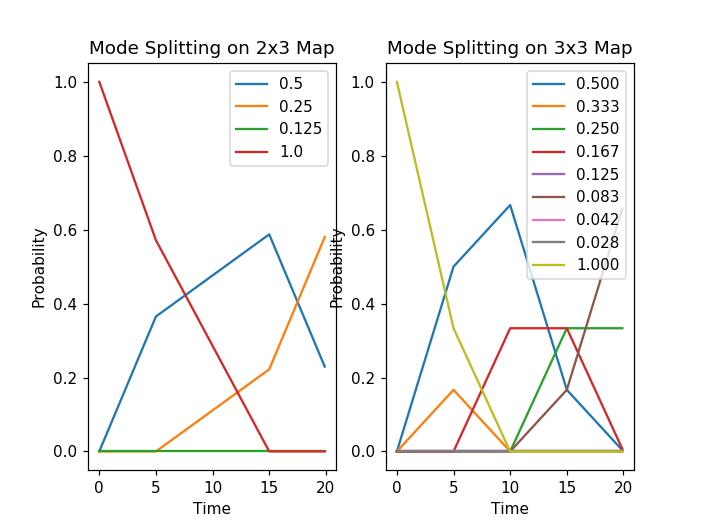

In [84]:
dist_e = 50
edge_dur = dist_e/v0
duration = 20
v0 = 10
map_dict2x3 = {
    'base': {
        'offsets': [0,0],
        'options': [0,1],
        'range': [3*edge_dur, edge_dur],
        'prob': [6./7, 1./7]
    },
    0: {'offsets': [3*edge_dur,edge_dur],
       'options': [0,1],
       'range': 3*edge_dur,
       'prob':4./6},#4/6
    1: {'offsets': [3*edge_dur,3*edge_dur],
       'options': [0,0],
       'range': edge_dur,
       'prob': 1./7}
}
t, test_data, prob_data = getModeProbabilities(map_dict2x3, dt, duration)
# plt.figure()
fig, ax = plt.subplots(1,2)
ax[0].set_title("Mode Splitting on 2x3 Map")
for key in prob_data:
    ax[0].plot(t,prob_data[key], label=1/key)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Probability")
ax[0].legend()

map_dict3x3 = {
    'base': {
        'offsets': [0,0,0],
        'options': [0,1,2],
        'range': [2*edge_dur, edge_dur, edge_dur],
        'prob': [4./6, 1./6, 1./6]
    },
    0: {'offsets': [2*edge_dur,edge_dur],
       'options': [0,1],
       'range': 2*edge_dur,
       'prob':4./6},#4/6
    1: {'offsets': [edge_dur, edge_dur, edge_dur],
       'options': [2,2,2],
       'range': edge_dur,
       'prob': 1./6},#1/6
    2: {'offsets': [2*edge_dur,2*edge_dur],
       'options': [0,0],
       'range': edge_dur,
       'prob': 1./6}#1/6
}
t, test_data, prob_data = getModeProbabilities(map_dict3x3, dt, duration)
# plt.figure()
ax[1].set_title("Mode Splitting on 3x3 Map")
for key in prob_data:
    ax[1].plot(t,prob_data[key], label="{:.3f}".format(1/key))
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Probability")
ax[1].legend()

### With Merging
#### From Simulator

<IPython.core.display.Javascript object>


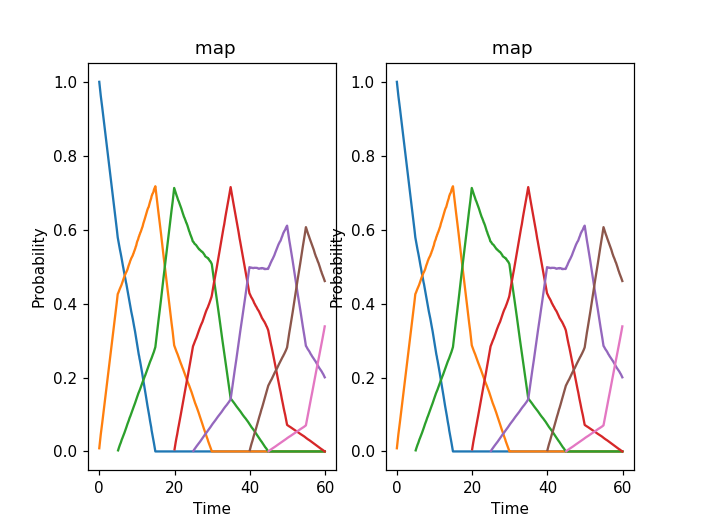

In [87]:
import mode_splitting
reload(mode_splitting)
from mode_splitting import getModeProbabilities, getAvgModeDataOverTime, plotModeData

dt = .1
duration = 60
num_runs = 10000
dists = [50, 100, 150, 200, 250, 300]
for idx in tnrange(len(dists)):

    layout = (2,3)
#     modes_over_time_2x3_merged_raw = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs, merging_allowed=True)
#     np.save("data/ModesFromSimulationMerged2x3-{}".format(dists[idx]), modes_over_time_2x3_raw)
    # tmp = modes_over_time_2x3_raw
    modes_over_time_2x3_raw = np.load("data/ModesFromSimulationMerged2x3-{}.npy".format(dists[idx])).item()

    modes_over_time_2x3_merged = {}
    for key in modes_over_time_2x3_raw.keys():
        modes_over_time_2x3_merged[key] = key*modes_over_time_2x3_raw[key]

    layout = (3,3)
#     modes_over_time_3x3_merged_raw = getAvgModeDataOverTime(dt,duration,dist_e,layout,num_runs, merging_allowed=True)
#     np.save("data/ModesFromSimulationMerged3x3-{}".format(dists[idx]), modes_over_time_2x3_raw)
    modes_over_time_3x3_raw = np.load("data/ModesFromSimulationMerged3x3-{}.npy".format(dists[idx])).item()
    modes_over_time_3x3_merged = {}
    for key in modes_over_time_3x3_raw.keys():
        modes_over_time_3x3_merged[key] = key*modes_over_time_3x3_raw[key]
fig, ax = plt.subplots(1,2)
plotModeData(ax[0], modes_over_time_2x3_merged, dt, duration)
plotModeData(ax[1], modes_over_time_3x3_merged, dt, duration)

#### From Formula

<IPython.core.display.Javascript object>


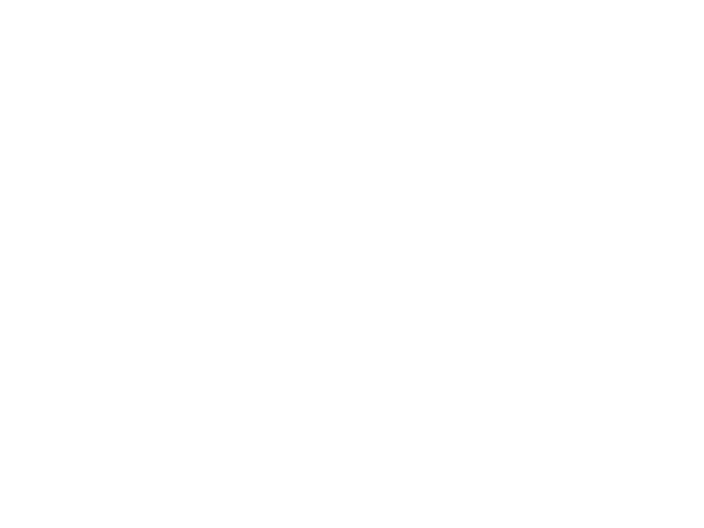

(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)


FileNotFoundError: [Errno 2] No such file or directory: 'data/entropy_growth_3x3-300-1_h_0.npy'

In [110]:
dists = [50,100,150,200,250,300]
plt.figure()
for dist in dists:
    ent = np.mean(np.load("data/entropy_growth_2x3-{}-1_h_0.npy".format(dist)), axis=0)
    print(ent.shape)
    plt.plot(ent)
    ent = np.mean(np.load("data/entropy_growth_3x3-{}-1_h_0.npy".format(dist)), axis=0)
    print(ent.shape)
    plt.plot(ent)

# Entropy Growth Over Time

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:403: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


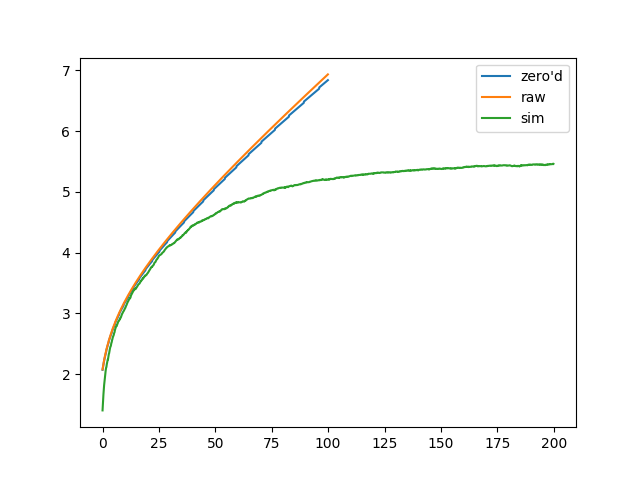

In [126]:
dist = 100
dists = [100]
Va = 40
dt = .1
sigma = 4
R = 5
num_edges = 7

probability_array = getProbabilityByDistsByTime([dist], dt, Va, v0, dur= 100)
probability_by_time = probability_array[0][0]
# data = np.load("data/ModesFromSimulation2x3-{}.npy".format(50))
# print(data.shape)
# data = np.load("data/data_2x3-{}-1_h_0.npy".format(dist))
# v_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dist))
# plot_data = np.mean(data, axis=0)
# t = np.array([idx*dt for idx in range(plot_data.shape[0])])

# avg_min_variance, variance_mins = get_avg_min_variance(v_data, data)

# dur = len(probability_by_time)*dt

avg_min_variance = getInitialVariance(2,3,dist,Va,dt,sigma,R)

map_size = num_edges*dist
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt,
                                                                 sigma, len(probability_by_time),
                                                                 probability_by_time, 1, zero_out=True)
t = [dt*idx for idx in range(len(predicted_ent))]
plt.figure()
plt.plot(t,predicted_ent, label="zero'd")
predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt,
                                                                 sigma, len(probability_by_time),
                                                                 probability_by_time, 1, zero_out=False)
plt.plot(t,predicted_ent, label='raw')
for dist in dists:
    data = np.load("data/entropy_growth_2x3-{}-1_h_0.npy".format(dist))
    data = np.mean(data, axis=0)
    t = [idx*dt for idx in range(data.shape[0])]
    plt.plot(t, data, label='sim')
plt.legend()
# plt.plot(plot_data)

<IPython.core.display.Javascript object>


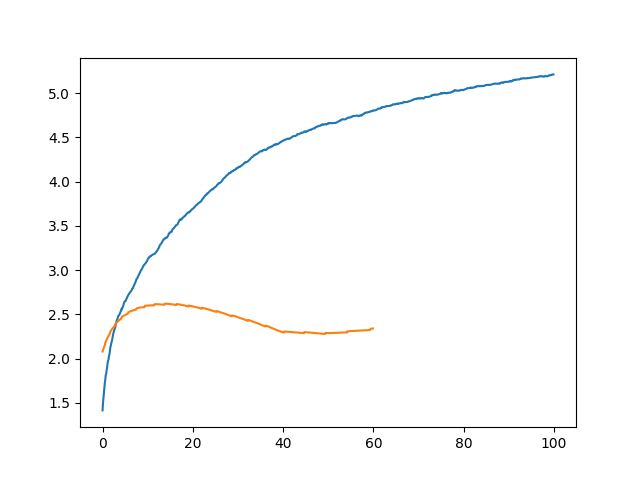

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:403: RuntimeWarning: divide by zero encountered in log


In [124]:
plt.figure()
dists = [100]
for idx in range(len(dists)):
    data = np.load("data/entropy_growth_2x3-{}-1_h_0.npy".format(dists[idx]))
    data = np.mean(data, axis=0)
    plt.plot([dt*jdx for jdx in range(data.shape[0])],data, label='sim')
    
    modes_over_time_2x3_raw = np.load("data/ModesFromSimulation2x3-{}.npy".format(dists[idx])).item()
    modes_over_time_2x3_merged = {}
    for key in modes_over_time_2x3_raw.keys():
        modes_over_time_2x3_merged[key] = key*modes_over_time_2x3_raw[key]
    probability_by_time = []
    for idx in range(len(modes_over_time_2x3_merged[1])):
        probability_by_time.append({
            key: modes_over_time_2x3_merged[key][idx]
         for key in modes_over_time_2x3_merged.keys()})
#     print(probability_by_time)
#     print(modes_over_time_2x3_merged.keys())
        
    predicted_est_by_time, predicted_ent = getProbAndEntropyOverTime(avg_min_variance, int(map_size), dt,
                                                                     sigma, len(probability_by_time),
                                                                     probability_by_time, 1, zero_out=True)
    plt.plot([dt*jdx for jdx in range(len(predicted_ent))],predicted_ent, label='raw')
    

# Entropy Lower Bound

## Single Mode

### Probability Matching

### Entropy Matching

## Multiple Modes

### Without Merging

<IPython.core.display.Javascript object>


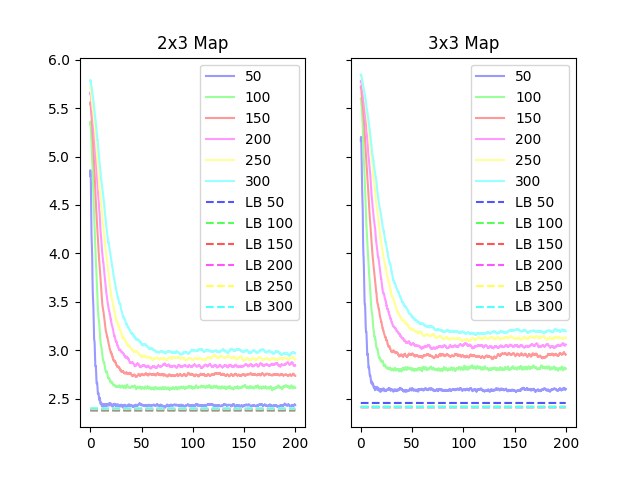

/home/mouse/.virtualenvs/deep/local/lib/python3.6/site-packages/ipykernel_launcher.py:403: RuntimeWarning: divide by zero encountered in log


In [142]:
dists = [50, 100, 150, 200, 250,300]
# dists = [100,300]
v0 = 10
Va = 40
R = 5
sigma = 4
dt = .1
colors = ['#9999FF', '#99FF99', '#FF9999', '#FF99FF', '#FFFF99', '#99FFFF', '#99999F', '#9999F9', '#999F99']
lower_bound_colors = ['#5555FF', '#55FF55', '#FF5555', '#FF55FF', '#FFFF55', '#55FFFF', '#55555F', '#5555F5', '#555F55']

ax, max_x = plotSimEntropy(dists, colors)

probability_array = getProbabilityByDistsByTime(dists, dt, Va, v0)

lower_bounds, predicted_lower_bounds, avg_min_variances = getLowerBounds(dists, 7, dt, sigma, Va, R,
                                                                         probability_array[0])
t = np.array([dt*idx for idx in range(max_x[0])])
for idx in range(len(dists)):
    ax[0].plot(t,[predicted_lower_bounds[idx] for jdx in range(max_x[0])], '--',
               color=lower_bound_colors[idx], label='LB {}'.format(dists[idx]))
ax[0].legend()

lower_bounds, predicted_lower_bounds, avg_min_variances = getLowerBounds(dists, 12, dt, sigma, Va, R,
                                                                         probability_array[1])
t = np.array([dt*idx for idx in range(max_x[1])])
for idx in range(len(dists)):
    ax[1].plot(t,[predicted_lower_bounds[idx] for jdx in range(max_x[1])], '--',
               color=lower_bound_colors[idx], label='LB {}'.format(dists[idx]))
ax[1].legend()

### With Merging

<IPython.core.display.Javascript object>


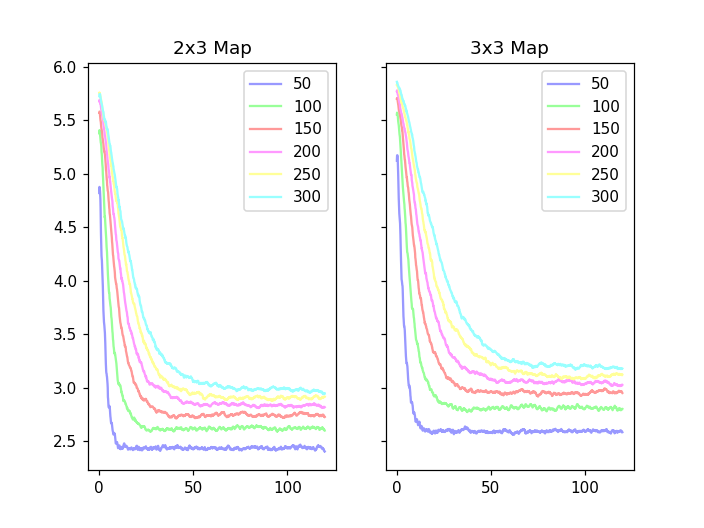

In [236]:
dists = [50, 100, 150, 200, 250,300]
v0 = 10
Va = 40
sigma = 4
dt = .1
colors = ['#9999FF', '#99FF99', '#FF9999', '#FF99FF', '#FFFF99', '#99FFFF', '#99999F', '#9999F9', '#999F99']
lower_bound_colors = ['#5555FF', '#55FF55', '#FF5555', '#FF55FF', '#FFFF55', '#55FFFF', '#55555F', '#5555F5', '#555F55']

ax, max_x = plotSimEntropy(dists, colors)

## Get Supercomputer data

<IPython.core.display.Javascript object>


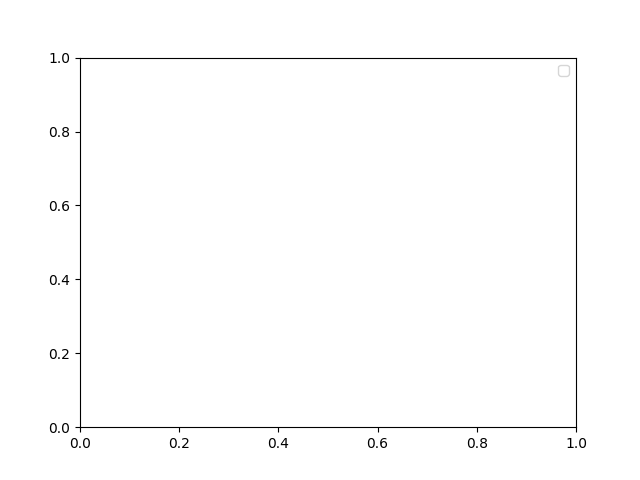

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


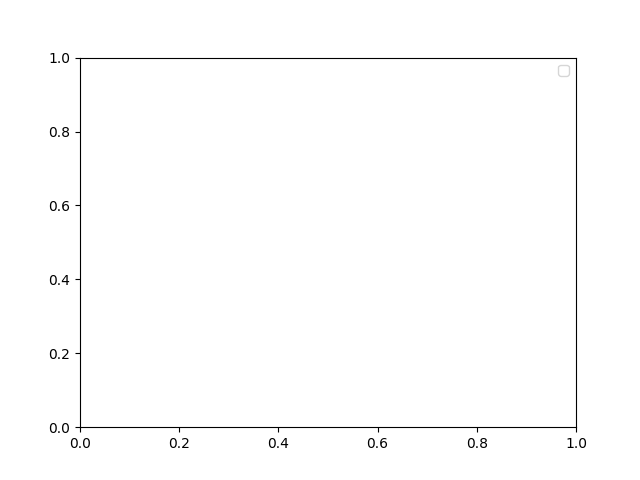

No handles with labels found to put in legend.


In [125]:

getSuperComputerData([50, 100, 150, 200, 250,300])

In [9]:
##
# def findDuplicates(dists, colors):
# #     fig, ax = plt.subplots(1,2, sharey=True)
#     max_x = [0, 0]
# #     ax[0].set_title("2x3 Map")
#     for idx in range(len(dists)):
#         data = np.mean(np.mean(np.load("data/data_2x3-{}-1_h_0.npy".format(dists[idx])),axis=0),axis=1)
#         v_data = np.load("data/data_2x3-{}-1_v_0.npy".format(dists[idx]))
#         unique, indices = np.unique(data, axis=0, return_index=True)
#         print(indices, len(indices), data.shape[0])
# #         t = [idx*dt for idx in range(data.shape[0])]
# #         max_x[0] = max(max_x[0], data.shape[0])
# #         ax[0].plot(t, data, color=colors[idx], label=dists[idx])
# #     ax[0].legend()

# #     ax[1].set_title("3x3 Map")
#     for idx in range(len(dists)):
#         data = np.mean(np.mean(np.load("data/data_3x3-{}-1_h_0.npy".format(dists[idx])),axis=0),axis=1)
#         v_data = np.load("data/data_3x3-{}-1_v_0.npy".format(dists[idx]))
#         unique, indices = np.unique(data, axis=0, return_index=True)
#         print(indices, len(indices), data.shape[0])
# #         t = [idx*dt for idx in range(data.shape[0])]
# #         ax[1].plot(t, data, color=colors[idx], label=dists[idx])
# #         max_x[1] = max(max_x[1], data.shape[0])
# #     ax[1].legend()
# #     return duplicates
# findDuplicates([50,150,200,250,300], colors)